# Lab 2-2: Economic Dispatch of Generators in a Power System
## 43026 Energy Economics, Optimisation and Policy
### Autumn 2025
### MATLAB Lab - Quadratic Programming Approach (Using Python)

---

## Lab Overview

This Python-based Jupyter Notebook helps you understand **economic dispatch using Quadratic Programming**. Our objective is to find the best way to distribute power generation among multiple generators at the **lowest cost** while ensuring that the **total power demand is met**.

Unlike **Linear Programming (LP)**, which assumes a constant fuel cost per MW, **Quadratic Programming (QP)** accounts for **diminishing returns** in power generation costs, making it a more **realistic approach**.

We use **Quadratic Programming (QP)**, a mathematical optimization method that **minimizes both linear and quadratic cost components** while satisfying constraints.

### In this Lab, We Will Learn:
- How to **represent generator costs** using both **linear and quadratic components**.
- How to **set up constraints** to ensure demand is met.
- How to **use Python’s `scipy.optimize.minimize` function** with the **trust-constr method** to solve the **Quadratic Programming problem**.

---

## Step 1: Install Required Python Libraries

Before running the code, ensure you have the necessary packages installed.

```python
!pip install numpy
!pip install -U matplotlib
!pip install scipy
```

Now, import the required libraries.

```python
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
```


In [1]:
!pip install numpy
!pip install -U matplotlib
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

---

## Step 2: Define Generator Data

Each generator has:
- **A fixed startup cost** (in dollars).
- **A fuel cost per MW** (how much it costs to produce 1 MW of power).
- **A quadratic cost coefficient** (representing diminishing returns on cost as power increases).
- **A minimum and maximum power limit**.

```python
# Number of generators
num_generators = 3

# Fixed startup cost ($) for each generator (not used in optimization)
startup_cost = np.array([100, 120, 90])

# Cost per MW ($/MW) for each generator (linear fuel cost)
fuel_cost = np.array([10, 12, 9])

# Quadratic cost coefficients (representing diminishing returns on cost as power increases)
quad_cost = np.array([0.05, 0.04, 0.06])

# Minimum and maximum power each generator can produce (MW)
P_min = np.array([50, 60, 40])
P_max = np.array([200, 180, 150])

# Total power demand (MW)
P_demand = 400

print("Generator data is set up.")
```



In [3]:
# Number of generators
num_generators = 3

# Fixed startup cost ($) for each generator (not used in optimization)
startup_cost = np.array([100, 120, 90])

# Cost per MW ($/MW) for each generator (linear fuel cost)
fuel_cost = np.array([10, 12, 9])

# Quadratic cost coefficients (representing diminishing returns on cost as power increases)
quad_cost = np.array([0.05, 0.04, 0.06])

# Minimum and maximum power each generator can produce (MW)
P_min = np.array([50, 60, 40])
P_max = np.array([200, 180, 150])

# Total power demand (MW)
P_demand = 400

print("Generator data is set up.")

Generator data is set up.


---

## Step 3: Define the Power Balance Constraint

To keep the **power grid stable**, the **total power generated must exactly match the total demand**:

$$ \sum_{i=1}^{n} P_i = P_{\text{demand}} $$

```python
# Constraint: Total power must equal demand
A_eq = np.ones((1, num_generators))  # Ensures sum of power outputs equals demand
b_eq = np.array([P_demand])  # Total power demand constraint

print("Power balance constraint is defined.")
print("A_eq matrix:", A_eq)
print("b_eq vector:", b_eq)
```



In [4]:
# Constraint: Total power must equal demand
A_eq = np.ones((1, num_generators))  # Ensures sum of power outputs equals demand
b_eq = np.array([P_demand])  # Total power demand constraint

print("Power balance constraint is defined.")
print("A_eq matrix:", A_eq)
print("b_eq vector:", b_eq)

Power balance constraint is defined.
A_eq matrix: [[1. 1. 1.]]
b_eq vector: [400]


---

## **Step 4: Define the Cost Function**

The cost function in **quadratic programming** consists of both **linear and quadratic terms**.

The **quadratic objective function** is:

$$
\min \sum_{i=1}^{n} ( c_i P_i + q_i P_i^2 )
$$

In **matrix form**, this is rewritten as:

$$
\min \frac{1}{2} P^T \text{diag}(q) P + c^T P
$$

where:
- $ c_i $ is the **linear fuel cost per MW** for generator $ i $.
- $ q_i $ is the **quadratic cost coefficient** for generator $ i $.
- $ P_i $ is the **power produced** by generator $ i $.
- $ T $ represents the **transpose operation**, which converts a column vector into a row vector.
- $ \text{diag}(q) $ denotes the **diagonal matrix** formed by placing the elements of $ q $ along the diagonal, ensuring that each generator’s quadratic cost is applied independently.

```python
# Define the cost function
def cost_function(P):
    return 0.5 * P.T @ np.diag(quad_cost) @ P + np.sum(fuel_cost * P)

print("Objective function (quadratic cost minimization) is defined.")
```

In [5]:
def cost_function(P):
    return 0.5 * P.T @ np.diag(quad_cost) @ P + np.sum(fuel_cost * P)

print("Objective function (quadratic cost minimization) is defined.")

Objective function (quadratic cost minimization) is defined.


## **Step 5: Solve Using Quadratic Programming**  

We use **Python’s `scipy.optimize.minimize` function** with the **trust-constr** method, which is suitable for **quadratic problems with constraints**.

---

### **Understanding `minimize` Function**
- **Objective function** → `cost_function(P)`, which calculates the **total generation cost** (linear + quadratic terms).  
- **Equality constraint** → Ensures the **total power generation meets demand**.  
- **Bounds** → Each generator operates within **its minimum and maximum limits**.  
- **Hessian function** → Provides **second-order derivatives** to optimize the quadratic cost efficiently.  

In [ ]:
# Define the equality constraint (power balance)
constraints = ({'type': 'eq', 'fun': lambda P: np.sum(P) - P_demand})

# Define bounds for each generator
bounds = list(zip(P_min, P_max))

# Initial guess (evenly distributed power)
P_initial = np.full(num_generators, P_demand / num_generators)

def hessian_function(P, *args):
    """Return the constant Hessian matrix to avoid numerical approximation errors."""
    return np.diag(quad_cost)  # The Hessian is constant (diagonal quadratic cost matrix)

# Solve using Quadratic Programming
result = minimize(cost_function, P_initial, method="trust-constr", bounds=bounds, constraints=constraints,  hess=hessian_function)

# Extract results
P_opt = result.x
total_cost = result.fun

print("\nOptimal power dispatch solution:")
print(P_opt)
print(f"Total Cost: ${total_cost:.2f}")



Optimal power dispatch solution:
[140.54053871 125.67567953 133.78378177]
Total Cost: $5464.19


---

## Step 6: Visualizing the Results

To better understand the results, we **plot the optimal power distribution** among the generators.

```python
# Plot the power allocation for each generator
plt.figure(figsize=(8, 5))
plt.bar(range(1, num_generators + 1), P_opt, color='b')
plt.xlabel("Generator Index")
plt.ylabel("Power Output (MW)")
plt.title("Optimal Power Dispatch")
plt.grid(True)
plt.show()
```



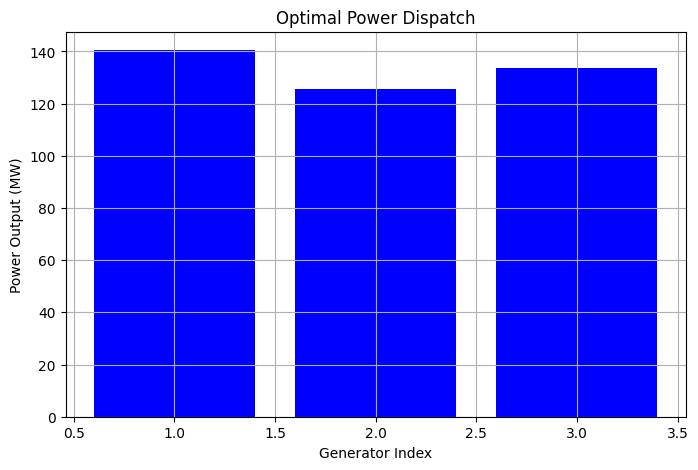

In [9]:
# Plot the power allocation for each generator
plt.figure(figsize=(8, 5))
plt.bar(range(1, num_generators + 1), P_opt, color='b')
plt.xlabel("Generator Index")
plt.ylabel("Power Output (MW)")
plt.title("Optimal Power Dispatch")
plt.grid(True)
plt.show()

---

## Step 7: More Realistic Case (7 Generators)

We now consider **7 generators** with different costs and power limits.


In [10]:
# Step 7.1: Define Generator Data

num_generators = 7  # Number of generators

# Generator parameters (Startup cost, fuel cost, quadratic cost)
startup_cost = np.array([100, 120, 90, 150, 110, 130, 95])  # Not used in optimization
fuel_cost = np.array([10, 12, 9, 14, 11, 13, 8])  # Linear fuel cost ($/MW)
quad_cost = np.array([0.05, 0.04, 0.06, 0.07, 0.05, 0.06, 0.04])  # Quadratic cost coefficients

# Power limits for each generator (MW)
P_min = np.array([50, 60, 40, 70, 55, 65, 45])  # Minimum power limits
P_max = np.array([200, 180, 150, 220, 190, 210, 160])  # Maximum power limits

# Total load demand (MW)
P_demand = 800

# ===================================================================================
# Step 7.2: Define Optimization Constraints

# Power balance constraint: Ensures total power output equals demand
A_eq = np.ones((1, num_generators))  
b_eq = np.array([P_demand])  

# Define generator power limits as bounds
bounds = list(zip(P_min, P_max))

# Define the quadratic cost matrix (equivalent to MATLAB's diag(quad_cost))
Q = np.diag(quad_cost)

# ===================================================================================
# Step 7.3: Define Cost Function (Objective Function)

def cost_function(P):
    """Compute the total cost, including quadratic and linear terms."""
    return 0.5 * P.T @ Q @ P + np.sum(fuel_cost * P)

# Define the equality constraint in Python format (ensures power balance)
constraints = ({'type': 'eq', 'fun': lambda P: np.sum(P) - P_demand})

# Initial guess: Evenly distribute the power demand among generators
P_initial = np.full(num_generators, P_demand / num_generators)

# ===================================================================================
# Step 7.4: Define Hessian Function (Fixed)

def hessian_function(P, *args):
    """Return the constant Hessian matrix (Q) to avoid numerical approximation errors."""
    return Q  # The Hessian is constant (diagonal quadratic cost matrix)

# ===================================================================================
# Step 7.5: Solve Using Quadratic Programming (Trust-Constr Method)

result = minimize(cost_function, P_initial, method="trust-constr",
                  bounds=bounds, constraints=constraints, hess=hessian_function)

# Extract results
P_opt = result.x
total_cost = result.fun

# ===================================================================================
# Step 7.6: Display the Results

print("\nOptimal Power Dispatch for 7 Generators (Quadratic Programming):")
print(P_opt)
print(f"Total Cost: ${total_cost:.2f}")


Optimal Power Dispatch for 7 Generators (Quadratic Programming):
[136.73469911 120.91836652 130.61224908  70.00000007 116.73468301
  65.00000227 159.99999994]
Total Cost: $10805.51


---

## Step 8: Visualizing the 7-Generator Case

```python
# Visualization: Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(range(1, num_generators + 1), P_opt, color='b')
plt.xlabel("Generator Number")
plt.ylabel("Power Output (MW)")
plt.title("Optimal Power Dispatch for 7 Generators (Quadratic Programming)")
plt.grid(True)
plt.xticks(range(1, num_generators + 1))
plt.ylim([0, max(P_max) + 20])
plt.show()
```


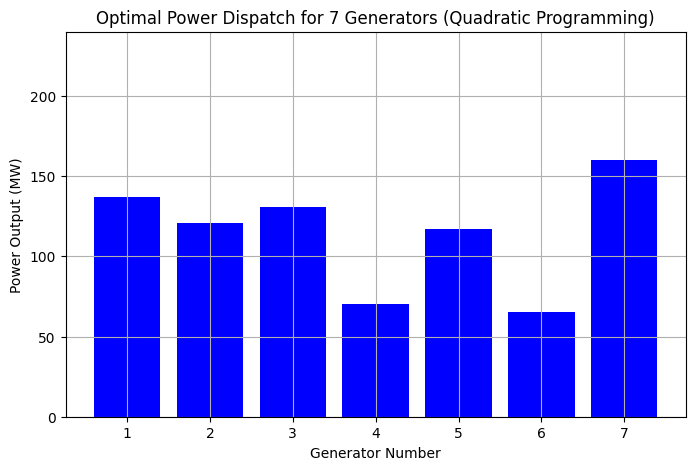

In [11]:
# Visualization: Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(range(1, num_generators + 1), P_opt, color='b')
plt.xlabel("Generator Number")
plt.ylabel("Power Output (MW)")
plt.title("Optimal Power Dispatch for 7 Generators (Quadratic Programming)")
plt.grid(True)
plt.xticks(range(1, num_generators + 1))
plt.ylim([0, max(P_max) + 20])
plt.show()

---

## **Step 9: Summary**

- **Defined** the economic dispatch problem using **quadratic programming**.
- **Formulated** the cost function with **both linear and quadratic components**.
- **Explained** the **mathematical transformation** from scalar form to matrix form.
- **Clarified the role of `0.5` in the quadratic term**.
- **Explained `minimize` function parameters** and solver alternatives.
- **Solved** the optimization problem using **`scipy.optimize.minimize`**.
- **Visualized** the optimal power allocation among generators.

---

### **Mathematical Summary**

#### **🔹 Step 1: Understanding the Scalar Form**  
The cost function for each generator $ i $ is typically modeled as:

$$
\min \sum_{i=1}^{n} ( c_i P_i + q_i P_i^2 )
$$

where:
- $ c_i $ is the **linear fuel cost per MW** for generator $ i $.
- $ q_i $ is the **quadratic cost coefficient** for generator $ i $.
- $ P_i $ is the **power produced** by generator $ i $.

The **linear term** ($ c_i P_i $) represents a **constant fuel rate**, while the **quadratic term** ($ q_i P_i^2 $) models the increasing cost of generation due to **diminishing efficiency** at higher loads.

---

#### **🔹 Step 2: Converting to Matrix Form**  
For **multiple generators**, we express the function in **matrix notation** for computational efficiency:

$$
\min \frac{1}{2} P^T \text{diag}(q) P + c^T P
$$

where:
- $ P $ is an **$ n \times 1 $** vector representing power generation for all generators:

  $$
  P = \begin{bmatrix} P_1 \\ P_2 \\ \vdots \\ P_n \end{bmatrix}
  $$

- $ c $ is an **$ n \times 1 $** vector containing the **linear fuel cost coefficients**:

  $$
  c = \begin{bmatrix} c_1 \\ c_2 \\ \vdots \\ c_n \end{bmatrix}
  $$

- $ q $ is an **$ n \times 1 $** vector containing the **quadratic cost coefficients**:

  $$
  q = \begin{bmatrix} q_1 \\ q_2 \\ \vdots \\ q_n \end{bmatrix}
  $$

- $ \text{diag}(q) $ is an **$ n \times n $** diagonal matrix that ensures each generator's quadratic cost is applied only to itself:

  $$
  \text{diag}(q) =
  \begin{bmatrix}
  q_1 & 0 & 0 & \dots & 0 \\
  0 & q_2 & 0 & \dots & 0 \\
  0 & 0 & q_3 & \dots & 0 \\
  \vdots & \vdots & \vdots & \ddots & \vdots \\
  0 & 0 & 0 & \dots & q_n
  \end{bmatrix}
  $$

---

#### **🔹 Why Use `0.5` in the Quadratic Term?**
- The **quadratic term is typically written as $ P^T H P $ in standard QP solvers**.
- However, during optimization, the solver **automatically computes the gradient $ \nabla P^T H P = 2 H P $**.
- To **prevent doubling the effect of the quadratic term**, we **explicitly multiply by `0.5`**.

Thus, the **final quadratic objective function** remains:

$$
\min \frac{1}{2} P^T \text{diag}(q) P + c^T P
$$

---

### **Additional Constraints**

1. **Total Power Balance Constraint**:

   $$
   \sum_{i=1}^{n} P_i = P_{\text{demand}}
   $$

2. **Quadratic Cost Function**:

   $$
   \min \sum_{i=1}^{n} ( c_i P_i + q_i P_i^2 )
   $$

3. **Bound Constraints**:

   $$
   P_{\min, i} \leq P_i \leq P_{\max, i}
   $$